# Chess AI - Predictions
The main goal of this Machine learning document is to train the AI's to play the popular game chess. I am going to use different model techniques and strategies, the version with the best score will be used in the next phase "Deployment".

AI's algoritmes I am going to use are:
- (Feed-forward) Neural Network
- Minimax

created by: Mickey krekels Class: AI45

---

## Loading the imports

In [1]:
import chess 
import chess.engine 
import random as r 
import numpy as np
from pandas import read_csv
import pandas as pd
import datetime
import chess.polyglot
import os


## Loading the chess board
In this part of the project, I am going to use the library [python-chess](https://pypi.org/project/python-chess/).This allows me the load in a chessboard with game rule already programmed. It also uses [chess FEN codes](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation#:~:text=Forsyth%E2%80%93Edwards%20Notation%20(FEN),game%20from%20a%20particular%20position.) . **FEN** stands for Forsyth-Edwards Notation, and it is the standard notation to describe pieces the positions of a chess game. Steven J. Edwards, a computer programmer, created this system so that chess software could use it. 

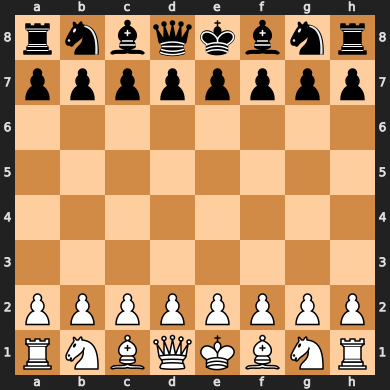

In [2]:
fen_StartingPosition = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"

board = chess.Board(fen_StartingPosition)
board

## Move the Pieces
To move the pieces in the game you give the board a string instruction, this is based on the position numbers and letters on the side of the board.

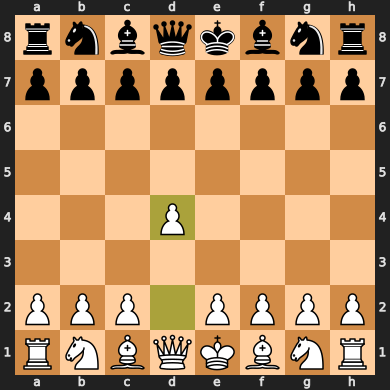

In [3]:
board.push_san("d2d4")
board

To save the current game, we create a FEN code from the positions currently on the board.

In [4]:
savedFen = board.fen()
savedFen

'rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1'

To load the saved FEN we create a new board with the FEN as a parameter.

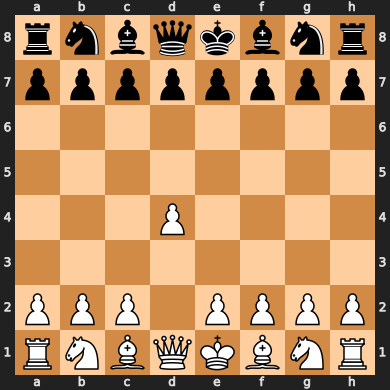

In [5]:
testingSavedBoard = chess.Board(savedFen)
testingSavedBoard

---
# Creating the Chess AI - Version 1


### Visualize the board in memory

To make the AI see the overall structure more clearly, we need to visualize the board in memory. This way the AI can calculate the best moves, we also assign values to the pieces so that the computer can see what pieces are more important (for example this way it does not sacrifice a queen for a pawn). 

### Piece square tables 
[Piece-Square Tables](https://www.chessprogramming.org/Piece-Square_Tables) is a technique that assigns pieces to the speiffict squares on the board. This is a great way for the AI to visualize the board.


In [59]:
pawntable = [
    0, 0, 0, 0, 0, 0, 0, 0,
    5, 10, 10, -20, -20, 10, 10, 5,
    5, -5, -10, 0, 0, -10, -5, 5,
    0, 0, 0, 20, 20, 0, 0, 0,
    5, 5, 10, 25, 25, 10, 5, 5,
    10, 10, 20, 30, 30, 20, 10, 10,
    50, 50, 50, 50, 50, 50, 50, 50,
    0, 0, 0, 0, 0, 0, 0, 0]

knightstable = [
    -50, -40, -30, -30, -30, -30, -40, -50,
    -40, -20, 0, 5, 5, 0, -20, -40,
    -30, 5, 10, 15, 15, 10, 5, -30,
    -30, 0, 15, 20, 20, 15, 0, -30,
    -30, 5, 15, 20, 20, 15, 5, -30,
    -30, 0, 10, 15, 15, 10, 0, -30,
    -40, -20, 0, 0, 0, 0, -20, -40,
    -50, -40, -30, -30, -30, -30, -40, -50]

bishopstable = [
    -20, -10, -10, -10, -10, -10, -10, -20,
    -10, 5, 0, 0, 0, 0, 5, -10,
    -10, 10, 10, 10, 10, 10, 10, -10,
    -10, 0, 10, 10, 10, 10, 0, -10,
    -10, 5, 5, 10, 10, 5, 5, -10,
    -10, 0, 5, 10, 10, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -10, -10, -10, -10, -20]

rookstable = [
    0, 0, 0, 5, 5, 0, 0, 0,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    5, 10, 10, 10, 10, 10, 10, 5,
    0, 0, 0, 0, 0, 0, 0, 0]

queenstable = [
    -20, -10, -10, -5, -5, -10, -10, -20,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -10, 5, 5, 5, 5, 5, 0, -10,
    0, 0, 5, 5, 5, 5, 0, -5,
    -5, 0, 5, 5, 5, 5, 0, -5,
    -10, 0, 5, 5, 5, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -5, -5, -10, -10, -20]

kingstable = [
    20, 30, 10, 0, 0, 10, 30, 20,
    20, 20, 0, 0, 0, 0, 20, 20,
    -10, -20, -20, -20, -20, -20, -20, -10,
    -20, -30, -30, -40, -40, -30, -30, -20,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30,
    -30, -40, -40, -50, -50, -40, -40, -30]

We assign an **importance value** to the board pieces.

In [60]:
pawn   = 100
knight = 320
bishop = 330
rook   = 500
queen  = 900

We now create a **evaluation function** that caculates the best score based on the moves on the board.

In [62]:
def Evaluate():
    if board.is_checkmate():
        if board.turn:
            return -9999
        else:
            return 9999
        
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
    
    material = MaterialScore(board)
    
    pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
    pawnsq = pawnsq + sum([-pawntable[chess.square_mirror(i)]
                           for i in board.pieces(chess.PAWN, chess.BLACK)])
    knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
    knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)]
                               for i in board.pieces(chess.KNIGHT, chess.BLACK)])
    bishopsq = sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
    bishopsq = bishopsq + sum([-bishopstable[chess.square_mirror(i)]
                               for i in board.pieces(chess.BISHOP, chess.BLACK)])
    rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)])
    rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)]
                           for i in board.pieces(chess.ROOK, chess.BLACK)])
    queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)])
    queensq = queensq + sum([-queenstable[chess.square_mirror(i)]
                             for i in board.pieces(chess.QUEEN, chess.BLACK)])
    kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)])
    kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)]
                       for i in board.pieces(chess.KING, chess.BLACK)])
    
    evaluation = material + pawnsq + knightsq + bishopsq + rooksq + queensq + kingsq
    if board.turn:
        return evaluation
    else:
        return -evaluation
    
    
    
    
def MaterialScore(board):
    wp = len(board.pieces(chess.PAWN, chess.WHITE))
    bp = len(board.pieces(chess.PAWN, chess.BLACK))
    wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
    bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
    wb = len(board.pieces(chess.BISHOP, chess.WHITE))
    bb = len(board.pieces(chess.BISHOP, chess.BLACK))
    wr = len(board.pieces(chess.ROOK, chess.WHITE))
    br = len(board.pieces(chess.ROOK, chess.BLACK))
    wq = len(board.pieces(chess.QUEEN, chess.WHITE))
    bq = len(board.pieces(chess.QUEEN, chess.BLACK))
    
    material = pawn * (wp - bp) + knight * (wn - bn) + bishop * (wb - bb) + rook * (wr - br) + queen * (wq - bq)
    return material

    

## Minimax Algorithm 
[Minimax](https://en.wikipedia.org/wiki/Minimax#:~:text=A%20minimax%20algorithm%20is%20a,or%20state%20of%20the%20game.&text=The%20player%20then%20makes%20the,the%20opponent's%20possible%20following%20moves.) is in a way a backtracking algorithm, It is used in decision making and game theory to find the optimal move for a player, presuming that the contender also plays optimally.The maximizer tries to calculate the highest score possible, whilst the minimizer tries to do the contrary and get the lowest score possible.Based on te score the AI calculates its best posible next move.

### Load in reference moves
This bin file contains initial moves from a book with a lot of opening moves for the chess.This way the AI does not play the game the same and in general it is proforming better!

In [49]:
bookPath = "D:/AI_software/Jupyter/Saved Files/Open Programme/data/human.bin"

In [63]:
def selectmove(depth,board,openingMovesTable = True):
    if openingMovesTable == True:
        try:
            move = chess.polyglot.MemoryMappedReader(bookPath).weighted_choice(board).move
            return move
        except:
            return Negamax(depth)
    else:
        return Negamax(depth)
    
    
def Negamax(depth):
    bestMove = chess.Move.null()
    bestValue = -99999
    alpha = -100000
    beta = 100000
    
    for move in board.legal_moves:
        board.push(move)
        boardValue = -alphabeta(-beta, -alpha, depth - 1)
        if boardValue > bestValue:
            bestValue = boardValue
            bestMove = move
        if (boardValue > alpha):
            alpha = boardValue
        board.pop()
        
    return bestMove

###  Alpha-Beta pruning
To optimization of our execution speed we are going to use [Alpha-Beta pruning](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) technique. Alpha-beta pruning is a modified version of the minimax algorithm, it amount of branches to examine are exponential in depth of the tree. Therefore this is a approach where without checking each node of the tree we can caclulate the accurate minimax decision.

In [64]:
def alphabeta(alpha, beta, depthleft):
    bestscore = -9999
    if (depthleft == 0):
        return quiesce(alpha, beta)
    for move in board.legal_moves:
        board.push(move)
        score = -alphabeta(-beta, -alpha, depthleft - 1)
        board.pop()
        if (score >= beta):
            return score
        if (score > bestscore):
            bestscore = score
        if (score > alpha):
            alpha = score
            
    return bestscore

### Quiescence search
[Quiescence search](https://www.chessprogramming.org/Quiescence_Search) is an extra added search, starting beginning nodes of the main search.In the game chess, quiescence searches usually incorporates all capture moves, so that strategical exchanges does not damage the evaluation.A quiescence search attempts to copy human behavior by instructing a computer to search unstable positions to a greater depth than "quiet" ones to make sure there are no hidden better moves left and to approximate a better sence of its value.

In [65]:
def quiesce(alpha, beta):
    stand_pat = Evaluate() # calls the Evaluation function
    if (stand_pat >= beta):
        return beta
    if (alpha < stand_pat):
        alpha = stand_pat
    for move in board.legal_moves:
        if board.is_capture(move):
            board.push(move)
            score = -quiesce(-beta, -alpha)
            board.pop()
            
            if (score >= beta):
                return beta
            if (score > alpha):
                alpha = score
            
    return alpha

(I used [this](https://www.youtube.com/watch?v=-ivz8yJ4l4E) video to get a better understanding about the concepts of Minimax Algorithm and Alpha-beta Pruning)

---
## Testing the AI

After we created the AI learning structure we test our results.

In [13]:
import chess.svg
import chess.pgn
import chess.engine
from IPython.display import SVG

board = chess.Board(fen_StartingPosition)

### Model output
we predict the next move my calling this function. It returns the board start to end potion in a string.

In [14]:
mov = selectmove(1)
print(mov)

e2e4


### Letting the AI play against itself
In this part of the document, we let the AI play against itself.


White moves : g1f3 | in round:  1

Black moves : g8f6 | in round:  1

White moves : d2d4 | in round:  2

Black moves : f6e4 | in round:  2

White moves : b1d2 | in round:  3

Black moves : d7d5 | in round:  3

White moves : e2e3 | in round:  4

Black moves : b8c6 | in round:  4

White moves : f1d3 | in round:  5

Black moves : c8f5 | in round:  5

White moves : e1g1 | in round:  6

Black moves : e7e6 | in round:  6

White moves : d2e4 | in round:  7

Black moves : d5e4 | in round:  7

White moves : g2g4 | in round:  8

Black moves : f5g6 | in round:  8

White moves : d4d5 | in round:  9

Black moves : e6d5 | in round:  9

White moves : f3d4 | in round:  10

Black moves : c6d4 | in round:  10

White moves : e3d4 | in round:  11

Black moves : e4d3 | in round:  11

White moves : c2d3 | in round:  12

Black moves : f8d6 | in round:  12

White moves : c1e3 | in round:  13

Black moves : e8g8 | in round:  13

White moves : d1b3 | in round:  14

Black moves : d8h4 | in round:  14

White mov

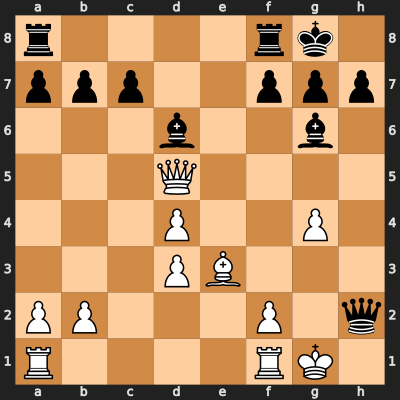

In [69]:
%%time
count = 0
movehistory = []
game = chess.pgn.Game()
board = chess.Board(fen_StartingPosition)
depht = 1

while not board.is_game_over(claim_draw=False):
    print()
    if board.turn: # whites turn
        count += 1
        move = selectmove(depht,board)
        board.push(move)
        print("White moves :", move, "| in round: ",count)
    else:
        move = selectmove(depht,board)
        board.push(move)
        print("Black moves :", move, "| in round: ",count)
    movehistory.append(move)

game.add_line(movehistory)

print()
game.headers["Event"] = "AI chess game"
game.headers["Site"] = "Bladel"
game.headers["Date"] = str(datetime.datetime.now().date())
game.headers["Round"] = 1
game.headers["White"] = "White Ai Team"
game.headers["Black"] = "Black Ai Team"
game.headers["Result"] = "White " + str(board.result(claim_draw=False)) +  " Black"

print(game)
SVG(chess.svg.board(board=board,size=400))

---
### Long computing Time
We now look at the increasing computing time, when we raise the depth parameter by one. The longer it is looking deeper in the MinMax search, the more steps it looks ahead.

The **openingMovesTable** parameter is going to be set to **False**, this way the AI is calculating all the moves.

In [16]:
board = chess.Board(fen_StartingPosition)

Wall time: 2 ms


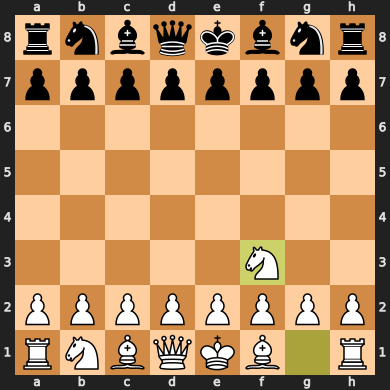

In [17]:
%%time
mov = selectmove(depth =1,openingMovesTable = False)
board.push(mov)
board

Wall time: 9 ms


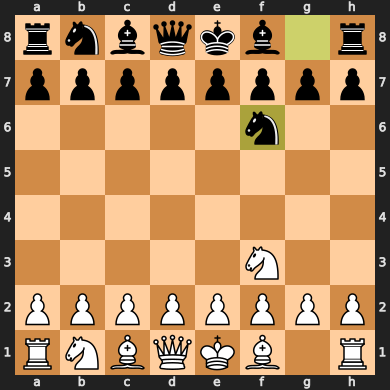

In [18]:
%%time
mov = selectmove(depth =2,openingMovesTable = False)
board.push(mov)
board

Wall time: 113 ms


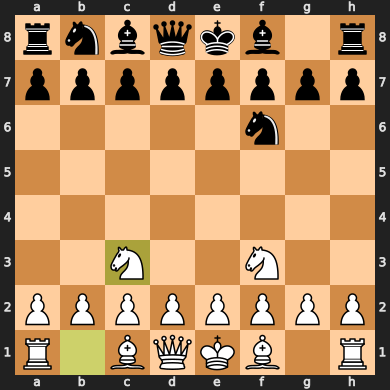

In [19]:
%%time
mov = selectmove(depth =3,openingMovesTable = False)
board.push(mov)
board

Wall time: 5.28 s


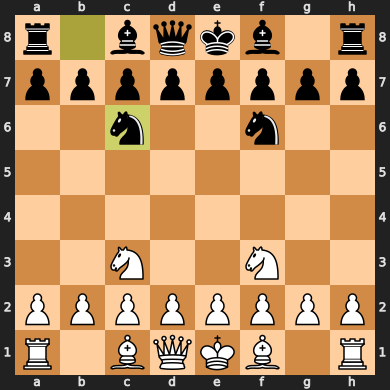

In [20]:
%%time 
mov = selectmove(depth =4,openingMovesTable = False)
board.push(mov)
board

Wall time: 2min 38s


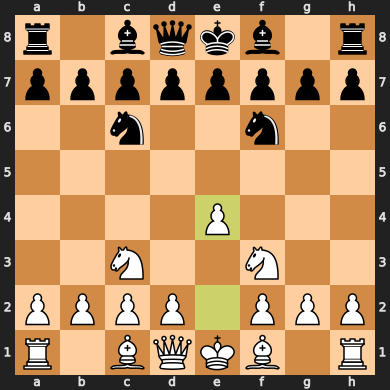

In [21]:
%%time 
mov = selectmove(depth =5,openingMovesTable = False)
board.push(mov)
board

After **depht 6**, the wall time can becomes hours long. 

# Chess AI - Version 1 Conclusion

This version works great, the AI is able to play against a human and itself. The **Minimax Algorithm** is an old technique for playing against a competitive computer and it works great for calculating an accurate move. We optimised the speed of the algorithm with **Alpha-Beta** pruning and the **Quiescence search**, but the computing time still takes way too long (see the increasing calculation time per depth level in the cells above). This currently a problem, because the deeper the algorithm searches the better it is at finding the opponents next move. So in the next version, we are going to look if we can improve this search by predicting values with a neural network.

---


# Creating the Chess AI - Version 2
In version 1, we create a model using a **Minimax Algorithm**. This works great for calculating the score, the only problem is that it can take a **lot of time** based on the **depth** of the search. In this version, I intend to fix that problem, to predict the score instead of computing it. In this version I am going to use the library Keras for their neural network, This allows for a lot of flexibility and optimization options. at the end of this version, there will also be an overall conclusion.


## Loading imports

In [22]:
from keras import callbacks, optimizers,models
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from matplotlib import pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Chess Dataset 
For this model I am going to use the data set "[Chess Game Dataset (Lichess)](https://www.kaggle.com/datasnaek/chess)". it is a set of just over 20,000 games collected. This dataset contains the columns:

- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, list here);
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

### Loading the path

In [23]:
dataPath = "D:/AI_software/Jupyter/Saved Files/Open Programme/data/games.csv"
saveLocation = "D:\AI_software\Jupyter\Saved Files\Open Programme\saves"

For this model I am going to use the columns winner and moves.

In [24]:
df = read_csv(dataPath)
df = df[df['winner']!='draw']
moves = df['moves'].values[:100]
winner = df['winner'].values
X = []
y = []

We create a dictionary of arrays with the FEN code pieces as key,this way the data can beused as an input for the network.

In [25]:
fen_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

This function turn the board input into data we can use for the model.

In [26]:
def build_matrix(board): 
    pgn = board.epd()
    matrix_x = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for i in rows:
        matrix_y = []  
        for j in i:
            if j.isdigit():
                for i in range(0, int(j)):
                    matrix_y.append('.')
            else:
                matrix_y.append(j)
        matrix_x.append(matrix_y)
    return matrix_x

def translate(matrix,fen_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(fen_dict[term])
        rows.append(terms)
    return rows

### Creating the Target Vector and Feature Matrix

We now load all of the pieces and positions in memeory with the **build_matrix** and **translate** function. After that we reshape and scale the data in to a useble Target Vector and Feature Matrix.

In [27]:
for game in moves:
    index = list(moves).index(game)
    all_moves = game.split()
    total_moves = len(all_moves)
    if winner[index] == 'black':
        game_winner = -1
    else:
        game_winner = 1
    board = chess.Board()
    for i in range(len(all_moves)):
        board.push_san(all_moves[i])
        value = game_winner * (i/total_moves)
        matrix = build_matrix(board.copy())
        rows = translate(matrix,fen_dict)
        X.append([rows])
        y.append(value)
        
X = np.array(X).reshape(len(X),8,8,12)
y = np.array(y)
X.shape

(4698, 8, 8, 12)

### Making the model
For the model structure I use the layer: 
- 64 (board tiles input)
- 24 (hidden layer)
- 10 (hidden layer)
- 1  (the board Evaluation score output)

As the activation function I will use **relu**. 

In version one we caculated the best score for each of the allowed moves on the board, based on that score the best move was chosen. In this version, instead of computing the score we **predict** it. This allows for much **greater compute speed**, and the **caculation time** should be **more stable**. 

In [28]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=24, kernel_size=1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'tanh'))

model.compile(optimizer='Nadam', loss='mse')

## Training the model 
We now **train** the model with our shaped X and Y data. We also loop throug these cells, so that why we **load** the saved model at this point.

In [29]:
model = models.load_model(saveLocation)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp09xz5j6k.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp09xz5j6k.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
training is  0.0 % done!
training is  10.0 % done!
training is  20.0 % done!
training is  30.0 % done!
training is  40.0 % done!
training is  50.0 % done!
training is  60.0 % done!
training is  70.0 % done!
training is  80.0 % done!
training is  90.0 % done!
Training the model is complete!
Wall time: 19min 44s


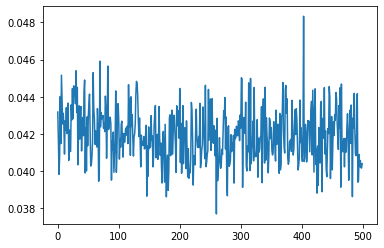

In [30]:
%%time 
amount = 10
epochs = 500

for i in range(amount):
    history = model.fit(X,y,epochs = epochs,verbose = 0)
    print("training is ",(((i/amount)*100)), "% done!")

print("Training the model is complete!")
plt.plot(history.history['loss'])

After the model is done training, we **save** the result and see what the AI is able to predict.

In [31]:
model.save(saveLocation)

INFO:tensorflow:Assets written to: D:\AI_software\Jupyter\Saved Files\Open Programme\saves\assets


### Testing the model with random board positions
Here we test if the new model can **predict the score** of the positions of the board, based on that we can included it in our new evalution function.

Board Evaluation: 0.271886


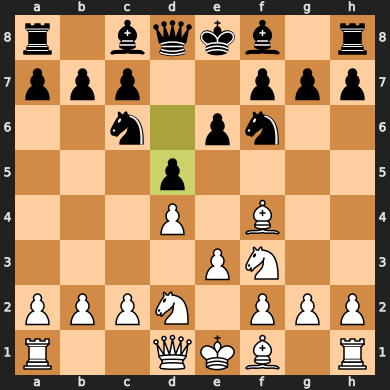

In [32]:
randint = np.random.randint(1,len(moves))
randint2 = np.random.randint(1,len(moves[randint].split()))
board = chess.Board(fen_StartingPosition)

for i in range(randint2):
    board.push_san(moves[randint].split()[i])
matrix = build_matrix(board.copy())
rows = translate(matrix,fen_dict)
print('Board Evaluation:',model.predict([rows])[0][0])
board

### Predicting the next move
The logic works the same way as the **selectmove** fucntion.The only difrence is that we **predict** the score with the model instead of calculating it with **negaMax**.

In [33]:
def NextMoveWith_NN(board,openingMovesTable = True):
    if openingMovesTable == True:
        try:
            move = chess.polyglot.MemoryMappedReader(bookPath).weighted_choice(board).move
            return move
        except:
            return PredictBestMove(board)
    else:
        return PredictBestMove(board)

def PredictBestMove(board):
    bestMove = chess.Move.null()
    bestValue = -99999
    
    for move in board.legal_moves:
        board.push(move)
        
        matrix = build_matrix(board.copy())
        rows = translate(matrix,fen_dict)
        boardValue = model.predict([rows])[0][0]
        
        if boardValue > bestValue:
            bestValue = boardValue
            bestMove = move
        board.pop()
        
    return bestMove

## Testing the Model Speed
like in the previous version were going to test the speed op the AI, By checking the wall time on each move. We repeat this a couple of times and see the overal **general speed**.

In [34]:
board = chess.Board(fen_StartingPosition)

Wall time: 764 ms


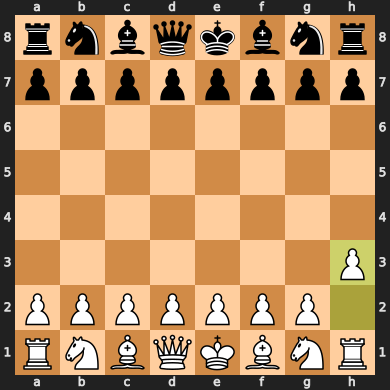

In [35]:
%%time
mov = NextMoveWith_NN(board,False)
board.push(mov)
board

Wall time: 767 ms


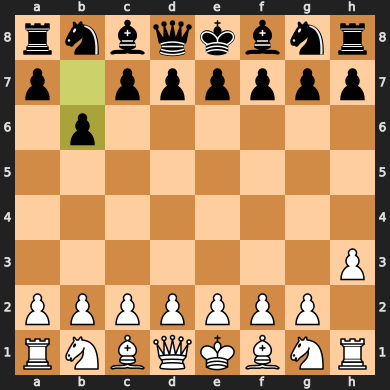

In [36]:
%%time
mov = NextMoveWith_NN(board,False)
board.push(mov)
board

Wall time: 898 ms


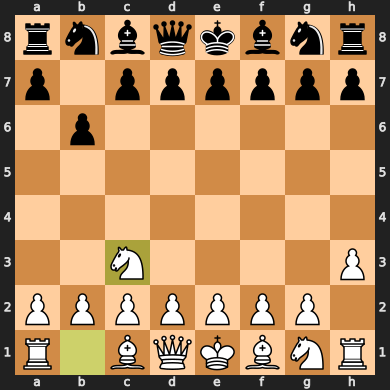

In [37]:
%%time
mov = NextMoveWith_NN(board,False)
board.push(mov)
board

The Speed of the model is between **600-800 ms** on average per turn, this is a way better result than the previous version!

### Letting the NN model play against itself
In this part of the document, we let the AI play against itself. We using the same technique as in the last version.


[Event "AI chess game"]
[Site "Bladel"]
[Date "2021-06-24"]
[Round "1"]
[White "White Ai Team"]
[Black "Black Ai Team"]
[Result "White 1/2-1/2 Black"]

1. Nf3 c5 2. c4 Nc6 3. Nc3 g6 4. g3 Bg7 5. Bg2 d6 6. O-O e6 7. e3 Nge7 8. d4 O-O 9. dxc5 dxc5 10. Qe2 a6 11. Rd1 Qc7 12. Bd2 b6 13. Na4 f6 14. Ne1 Bh6 15. Nxc5 Na5 16. Kf1 Bf4 17. Be4 Qb8 18. Bf5 Nb7 19. Nxb7 h6 20. Bxg6 Kh8 21. Bh7 Kg7 22. Bg8 Re8 23. Bh7 Rf8 24. Bg8 Re8 25. Bh7 Rf8 26. Bg8 Re8 27. Bh7 Rf8 28. Bg8 Re8 29. Bh7 Rf8 White 1/2-1/2 Black
Wall time: 47.1 s


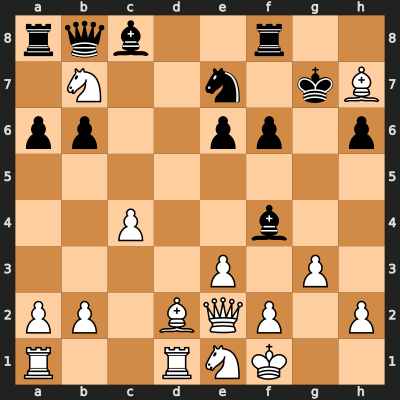

In [38]:
%%time
count = 0
movehistory = []
game = chess.pgn.Game()
board = chess.Board(fen_StartingPosition)
game.setup(board)

while not board.is_game_over():
    if board.turn: # whites turn
        count += 1
        move = NextMoveWith_NN(board)
        board.push(move)
        movehistory.append(move)
    else:
        move = NextMoveWith_NN(board)
        board.push(move)
        movehistory.append(move)

print()
game.add_line(movehistory)
game.headers["Event"] = "AI chess game"
game.headers["Site"] = "Bladel"
game.headers["Date"] = str(datetime.datetime.now().date())
game.headers["Round"] = 1
game.headers["White"] = "White Ai Team"
game.headers["Black"] = "Black Ai Team"
game.headers["Result"] = "White " + str(board.result()) +  " Black"
print(game)
SVG(chess.svg.board(board=board,size=400))

# Chess AI - Version 2 Conclusion

besides that the AI's calculation time is much faster, the result is not necessarily better than version 1. When I let the model play against itself it always ends in a draw. This probably means that the model at some point predicts the same moves over and over again. Due to the limited time frame, this is how far I will take this version. It was certainly interesting to see that the model can predict moves, even if there are not that great yet.

---

# Final Conclusion

During this project, I learned a lot about how the original chess AI was created. This proved to me how difficult it is to create a model that accurately can play as a human.

In version one, we looked at the old method, the algorithm Minimax. The AI works great and calculates the moves accurately. The downside of it is that the wall time is exponential based on the search depth level. At level 6, the calculating got even to hours long. This problem we tried to fix in version two, the neural network model. Wall time was around a steady 600 to 700 ms, which is a lot better than version one. The downside was that the model was not as accurate at predicting strategic moves. This can be possibly fixed by more training, but due to the current time I have left for this project, this is how far I will take this model. 

The both have positve and negative part, so I will use both AI for in the next phase.

#### End note
In short, the model that I created is completely playable on both versions. So based on that, I can conclude that this project was a great success!